# Estimate K corrections using AstroCLIP

In this notebook we will calculate galaxy K corrections using AstroCLIP model. 
* This is a regression task, the target predictions are Real numbers.
* The input of AstroCLIP can be either an image or a spectra, because it's a multimodal model.
* The most challenging task is to predict K corrections from images, so we will focus on the task of predicting K correction from images.

The embeddings calculated using the trained AstroCLIP models have already been stored in dataset `kcorr_ds`. This notebooks deals with training either zero-shot or few-shot models on top of these embeddings.


## Load the dataset

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from models.models import few_shot, zero_shot
from models.plotting import plot_scatter
from models.train_utils import calculate_zero_shot, calculate_few_shot, load_selected_columns_from_hdf5_chunks

In [2]:
import numpy as np
import torch
from astropy.table import Table, join
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

TRAIN_DS_PATH = "../data/kcorrs_train.hdf5"
TEST_DS_PATH =  "../data/kcorrs_test.hdf5"


In [3]:
selected_columns = ["TARGETID", "Z", "KCORR01_SDSS_R", "KCORR01_SDSS_G", "KCORR01_SDSS_Z", "image_embeddings"]
train_ds = load_selected_columns_from_hdf5_chunks(TRAIN_DS_PATH, selected_columns)

In [4]:
test_ds = load_selected_columns_from_hdf5_chunks(TEST_DS_PATH, selected_columns)

In [5]:
k_train, k_test = train_ds["KCORR01_SDSS_R"], test_ds["KCORR01_SDSS_R"]
z_train, z_test = train_ds["Z"], test_ds["Z"]

# Data visualization

* Data is split into a train and test set. Each sample is a galaxy identified by its TARGETID column.
* There are about 200k galaxies in total
* The quantities to predict are `KCORR_(..)` columns. In this notebook, we will exclusively focus on `KCORR01_SDSS_R`, the k correction at band SDSS-R with band shift 0.1 The procedure should be identical for other bands. 
* The column Z, redshift, is highlhy informative since it tells us how far each galaxy is. This column is not an input to the model, but it is useful to visualize the data and also the performance of the model as a function of Z.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

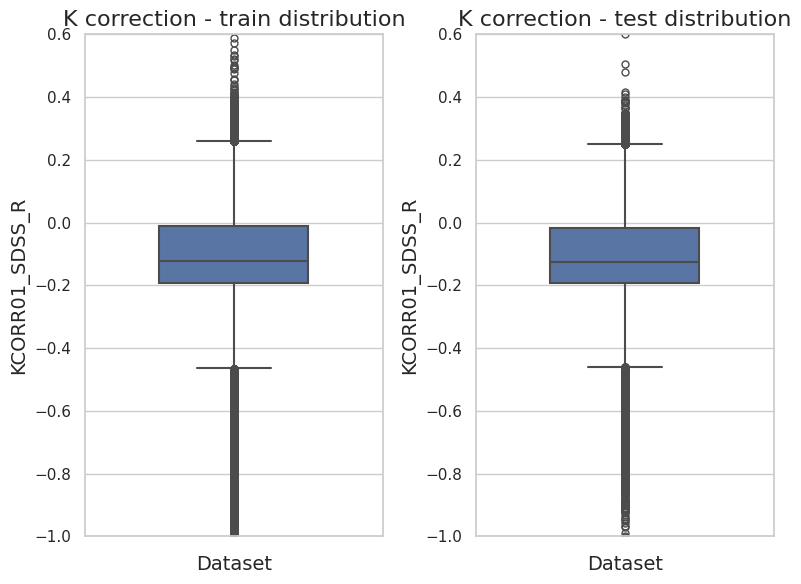

In [7]:
# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(8, 6))

# Plot the boxplot for k_train
plt.subplot(1, 2, 1)
sns.boxplot(data=k_train, width=0.5, fliersize=5, linewidth=1.5)
plt.title('K correction - train distribution', fontsize=16)
plt.ylabel('KCORR01_SDSS_R', fontsize=14)
plt.xlabel('Dataset', fontsize=14)
plt.ylim(-1, 0.6)  # Set the y-axis limits for k_train plot

# Plot the boxplot for k_test
plt.subplot(1, 2, 2)
sns.boxplot(data=k_test,  width=0.5, fliersize=5, linewidth=1.5)
plt.title('K correction - test distribution', fontsize=16)
plt.ylabel('KCORR01_SDSS_R', fontsize=14)
plt.xlabel('Dataset', fontsize=14)
plt.ylim(-1, 0.6)  # Set the y-axis limits for k_train plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

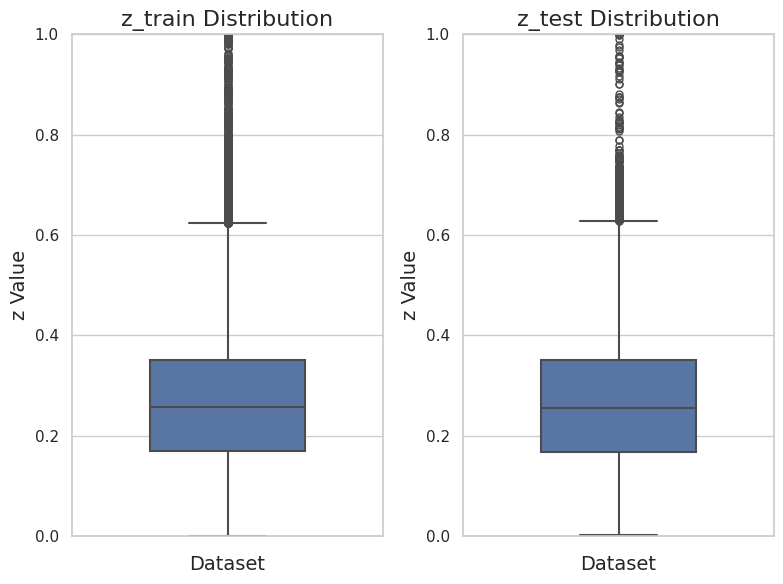

In [8]:
# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(8, 6))

# Plot the boxplot for k_train
plt.subplot(1, 2, 1)
sns.boxplot(data=z_train, width=0.5, fliersize=5, linewidth=1.5)
plt.title('z_train Distribution', fontsize=16)
plt.ylabel('z Value', fontsize=14)
plt.xlabel('Dataset', fontsize=14)
plt.ylim(0, 1)  # Set the y-axis limits for k_train plot

# Plot the boxplot for k_test
plt.subplot(1, 2, 2)
sns.boxplot(data=z_test,  width=0.5, fliersize=5, linewidth=1.5)
plt.title('z_test Distribution', fontsize=16)
plt.ylabel('z Value', fontsize=14)
plt.xlabel('Dataset', fontsize=14)
plt.ylim(0, 1)  # Set the y-axis limits for k_train plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


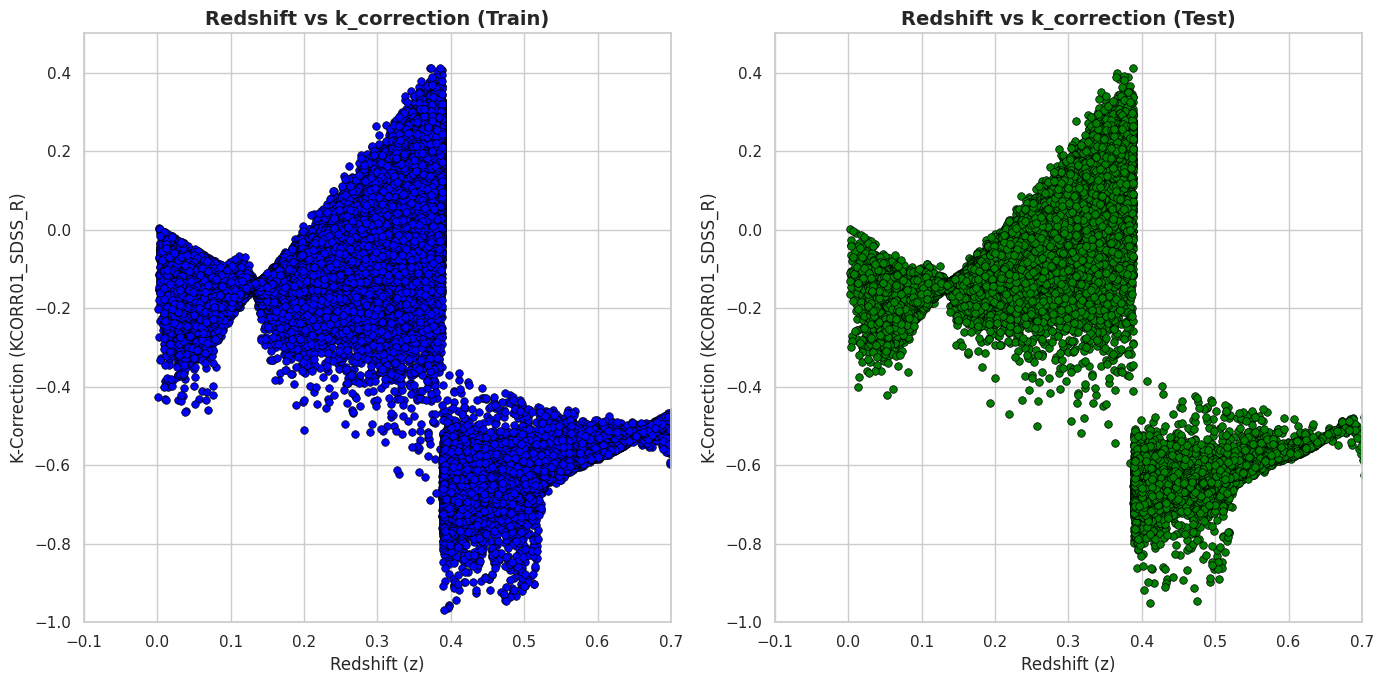

In [9]:
# Assuming z_train, k_train, z_test, and k_test are your data arrays
sns.set(style="whitegrid")  # Set a more polished style

# Create a 1 row, 2 columns plot using Seaborn's FacetGrid-like structure
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot the first scatter plot (z_train vs k_train) using sns.scatterplot
sns.scatterplot(x=z_train, y=k_train, ax=axes[0], color="blue", s=30, edgecolor="black", linewidth=0.5)
axes[0].set_xlim([-0.1, 0.7])  # Set custom xlim for the first plot
axes[0].set_ylim([-1, 0.5])  # Adjust ylim if needed
axes[0].set_title('Redshift vs k_correction (Train)', fontsize=14, weight='bold')
axes[0].set_xlabel('Redshift (z)', fontsize=12)
axes[0].set_ylabel('K-Correction (KCORR01_SDSS_R)', fontsize=12)

# Plot the second scatter plot (z_test vs k_test) using sns.scatterplot
sns.scatterplot(x=z_test, y=k_test, ax=axes[1], color="green", s=30, edgecolor="black", linewidth=0.5)
axes[1].set_xlim([-0.1, 0.7])  # Set custom xlim for the second plot
axes[1].set_ylim([-1, 0.5])  # Adjust ylim if needed
axes[1].set_title('Redshift vs k_correction (Test)', fontsize=14, weight='bold')
axes[1].set_xlabel('Redshift (z)', fontsize=12)
axes[1].set_ylabel('K-Correction (KCORR01_SDSS_R)', fontsize=12)

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()


# Prediction of K corrections: Zero shot
Let's use KNN on the embedding space to predict K corrections.

In [10]:
# Get data
data = {}
for model in ["image"]:
    data[model] = {}
    X_train, X_test = (
        train_ds[model + "_embeddings"],
        test_ds[model + "_embeddings"],
    )
    embedding_scaler = StandardScaler().fit(X_train)
    data[model]["train"] = embedding_scaler.transform(X_train)
    data[model]["test"] = embedding_scaler.transform(X_test)

# Zero shot experiments

## Restricted to redshift

In [11]:
preds_knn, k_test, stats = calculate_zero_shot(
    train_ds, test_ds, z_train, z_test, data, column_name= "KCORR01_SDSS_R",n_neighbors=64, redshift_upper_bound=0.37)

training with n_neighbors =  64


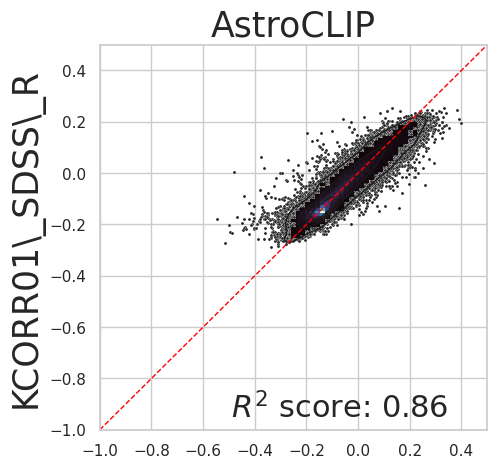

In [12]:
plot_scatter(preds_knn, k_test, data_lower_lim=-1, data_upper_lim = 0.5)

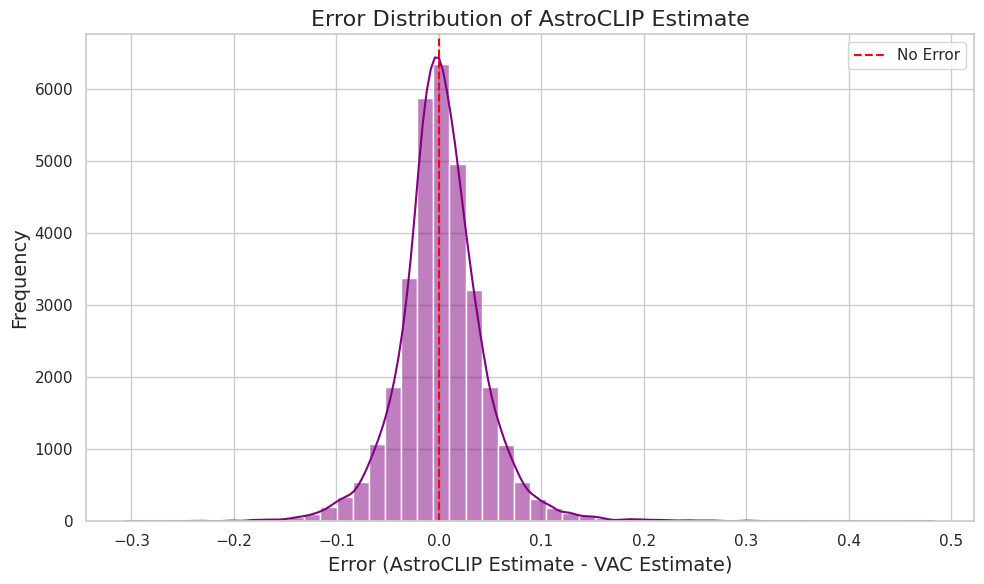

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the error
error = preds_knn['AstroCLIP'] - k_test
error = error[stats['z']<0.37]
# Plot the error distribution
plt.figure(figsize=(10, 6))
sns.histplot(error, kde=True, color="purple", bins=50)
plt.axvline(0, color='red', linestyle='--', label="No Error")
plt.xlabel("Error (AstroCLIP Estimate - VAC Estimate)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Error Distribution of AstroCLIP Estimate", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# Extract ground truth and predictions
y_true = k_test
y_pred = preds_knn['AstroCLIP']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Absolute Error (MAE): 0.0303
Mean Squared Error (MSE): 0.0018
Root Mean Squared Error (RMSE): 0.0427
R-squared (R²): 0.8564


## No redshift restriction

In [15]:
preds_knn, k_test, stats = calculate_zero_shot(train_ds, test_ds, z_train, z_test, data, n_neighbors=64, redshift_upper_bound=None)

training with n_neighbors =  64


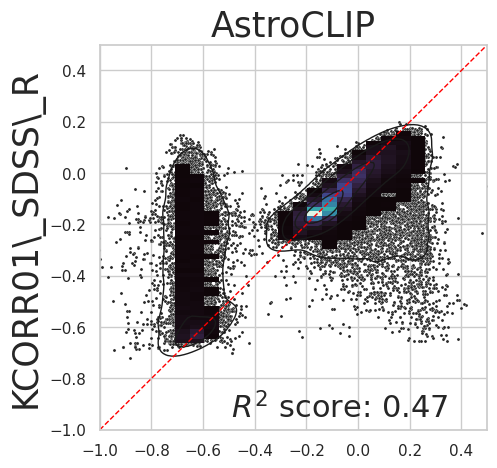

In [17]:
plot_scatter(preds_knn, k_test, data_lower_lim=-1, data_upper_lim = 0.5)

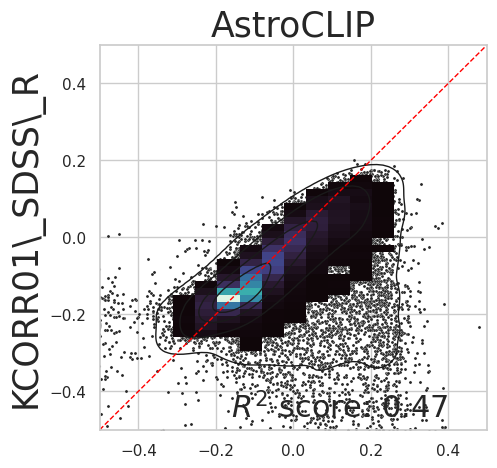

In [18]:
plot_scatter(preds_knn, k_test)

# Zero shot with uncertainty estimation
DO IT OVER

# Few shot
This section is under construction
TODO: Move implementation to source code

In [19]:
preds_mlp, k_test, stats = calculate_few_shot(train_ds, test_ds, z_train, z_test, data, column_name="KCORR01_SDSS_G", redshift_upper_bound=0.37)

In [36]:
import lightning as L
import pyro.distributions as dist
import pyro.distributions.transforms as T
import torch
import torch.nn.functional as F
import torchvision
from lightning import Trainer
from numpy import ndarray
from sklearn.neighbors import KNeighborsRegressor
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

class SelfAttentionMLP(nn.Module):
    def __init__(self, n_in, n_out, hidden_dims=(64, 64), num_heads=4, dropout=0.1):
        super().__init__()
        self.linear_in = nn.Linear(n_in, hidden_dims[0])
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dims[0], num_heads=num_heads, dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[1], n_out),
        )

    def forward(self, x):
        x = self.linear_in(x)
        x = x.unsqueeze(0)  # Add sequence dimension
        attn_out, _ = self.attention(x, x, x)
        x = attn_out.squeeze(0)  # Remove sequence dimension
        return self.mlp(x)
        
def attention_few_shot(
    X_train: ndarray,
    y_train: ndarray,
    X_test: ndarray,
    max_epochs: int = 10,
    hidden_dims: list[int] = [64, 64],
    lr: float = 1e-3,
) -> ndarray:
    """Train a few-shot model using a simple neural network"""
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    )
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    num_features = y_train.shape[1] if len(y_train.shape) > 1 else 1
    model = SelfAttentionMLP(
        n_in=X_train.shape[1],
        n_out=num_features,
        hidden_dims=hidden_dims,
        dropout=0.1,
    )

    # Set up the model
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    model.cuda()
    model.train()
    for epoch in range(max_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.cuda()).squeeze()
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Make predictions
    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(X_test, dtype=torch.float32).cuda()).cpu().numpy()
    return preds

In [38]:
def calculate_few_shot(
    train_ds, test_ds, z_train, z_test, data, column_name="KCORR01_SDSS_R", mlp_hidden_dims = [64, 64], redshift_upper_bound = None, plot=False):
    # Get retrieve_k_corrections
    k_train = train_ds[column_name]
    k_test = test_ds[column_name]
    z_train = train_ds["Z"]
    z_test = test_ds["Z"]

    train_data = data["image"]["train"]
    test_data = data["image"]["test"]

    if redshift_upper_bound != None:
        cond_tr = z_train <= redshift_upper_bound
        k_train = k_train[cond_tr]
        train_data = train_data[cond_tr]

        cond_test = z_test <= redshift_upper_bound
        k_test = k_test[cond_test]
        test_data = test_data[cond_test]
        
    # Scale properties
    scaler = {"mean": k_train.mean(), "std": k_train.std()}
    k_train = (k_train - scaler["mean"]) / scaler["std"]
    
    # Perfrom knn and mlp
    preds_knn, preds_mlp = {}, {}
    raw_preds_mlp = attention_few_shot(train_data, k_train, test_data, hidden_dims=mlp_hidden_dims)
    preds_mlp["astroclip_image"] = raw_preds_mlp * scaler["std"] + scaler["mean"]

    preds_mlp["AstroCLIP"] = preds_mlp.pop("astroclip_image")

    if plot:
        plot_scatter_astroclip_only(preds_mlp, k_test)

    mae_knn = np.mean(np.abs(preds_mlp['AstroCLIP'] - k_test))
    r2_knn = r2_score(k_test, preds_mlp['AstroCLIP'])

    stats = {
        "mae_knn" : mae_knn,
        "r2_knn" : r2_knn,
        "z" : z_test
    }

    return preds_mlp, k_test, stats

In [39]:
preds_mlp, k_test, stats = calculate_few_shot(train_ds, test_ds, z_train, z_test, data, column_name="KCORR01_SDSS_G", redshift_upper_bound=0.37)

In [40]:
print(stats)

{'mae_knn': 0.3713629, 'r2_knn': 0.3148607611656189, 'z': array([0.09371274, 0.09693657, 0.24033001, ..., 0.21955566, 0.18667958,
       0.38761424])}


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn

def few_shot_with_uncertainty(
    model: nn.Module,
    X_train: ndarray,
    y_train: ndarray,
    X_test: ndarray,
    max_epochs: int = 10,
    hidden_dims: list[int] = [64, 64],
    lr: float = 1e-3,
    mc_samples: int = 10,  # Number of Monte Carlo samples for uncertainty
) -> tuple[ndarray, ndarray]:
    """Train a few-shot model with uncertainty using dropout-based approximation."""
    # Prepare data
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    )
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Define the model
    num_features = y_train.shape[1] if len(y_train.shape) > 1 else 1
    model = MLP(
        n_in=X_train.shape[1],
        n_out=num_features,
        n_hidden=hidden_dims,
        act=[nn.ReLU()] * (len(hidden_dims) + 1),
        dropout=0.1,
    )

    # Set up the model
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    model.cuda()
    model.train()
    for epoch in range(max_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.cuda()).squeeze()
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Predict with uncertainty
    model.train()  # Keep dropout active for MC sampling
    preds_list = []
    with torch.no_grad():
        for _ in range(mc_samples):
            preds = model(torch.tensor(X_test, dtype=torch.float32).cuda()).cpu().numpy()
            preds_list.append(preds)
    preds_array = np.array(preds_list)

    # Compute final predictions and uncertainty
    final_preds = preds_array.mean(axis=0)  # Mean prediction
    uncertainty = preds_array.std(axis=0)  # Standard deviation as uncertainty

    return final_preds, uncertainty


In [ ]:
def calculate_few_shot_w_uncertainty(column_name="KCORR01_SDSS_R", mlp_hidden_dims = [64,64,64], redshift_upper_bound = None, plot=False):
    # Get retrieve_k_corrections
    k_train = train_ds[column_name]
    k_test = test_ds[column_name]
    z_train = train_ds["Z"]
    z_test = test_ds["Z"]

    train_data = data["astroclip_image"]["train"]
    test_data = data["astroclip_image"]["test"]

    if redshift_upper_bound != None:
        cond_tr = z_train <= redshift_upper_bound
        k_train = k_train[cond_tr]
        train_data = train_data[cond_tr]

        cond_test = z_test <= redshift_upper_bound
        k_test = k_test[cond_test]
        test_data = test_data[cond_test]
        
    # Scale properties
    scaler = {"mean": k_train.mean(), "std": k_train.std()}
    k_train = (k_train - scaler["mean"]) / scaler["std"]
    
    # Perfrom knn and mlp
    preds_knn, preds_mlp = {}, {}
    raw_preds_mlp, uncertainty = few_shot_with_uncertainty(
        model, train_data, k_train, test_data, hidden_dims=mlp_hidden_dims)
    preds_mlp["astroclip_image"] = raw_preds_mlp * scaler["std"] + scaler["mean"]

    preds_mlp["AstroCLIP"] = preds_mlp.pop("astroclip_image")

    if plot:
        plot_scatter_astroclip_only(preds_mlp, k_test)

    mae_knn = np.mean(np.abs(preds_mlp['AstroCLIP'] - k_test))
    r2_knn = r2_score(k_test, preds_mlp['AstroCLIP'])

    stats = {
        "mae_knn" : mae_knn,
        "r2_knn" : r2_knn
    }

    return preds_mlp, k_test, uncertainty.flatten(), stats

In [ ]:
preds_mlp, k_test, uncertainty, stats = calculate_few_shot_w_uncertainty(redshift_upper_bound=0.37)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b17f053a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b17f058e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b17f05100>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b17f05e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b17b10100>],
 'means': []}

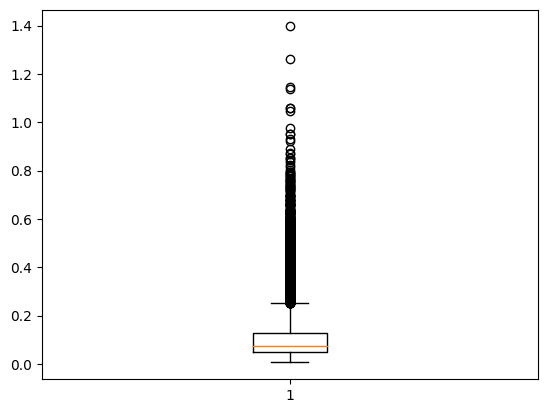

In [76]:
plt.boxplot(uncertainty)

In [77]:
print("Regular MAE:", np.mean(np.abs(preds_mlp['AstroCLIP'] - k_test)))
print("Uncertainty based MAE", np.mean(np.abs(preds_mlp['AstroCLIP'][uncertainty<0.2] - k_test[uncertainty<0.2])))

Regular MAE: 0.2042715
Uncertainty based MAE 0.14821579


Evaluating astroclip_image model...
Evaluating astroclip_image model...
Evaluating astroclip_image model...
Evaluating astroclip_image model...
Evaluating astroclip_image model...
Evaluating astroclip_image model...


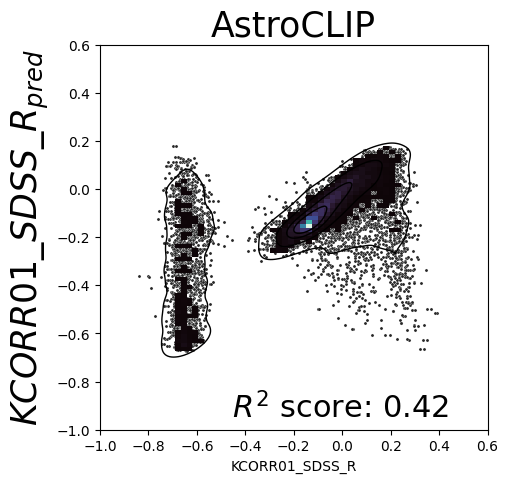

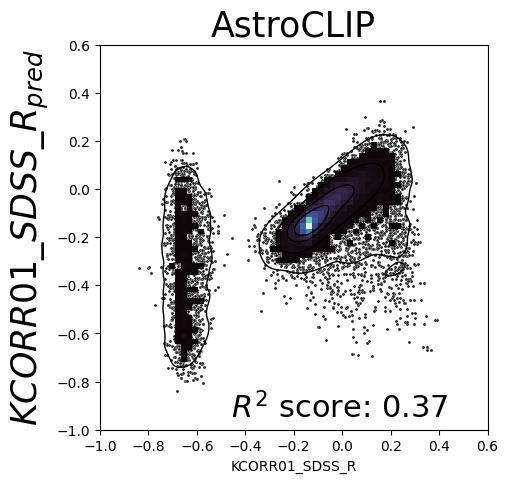

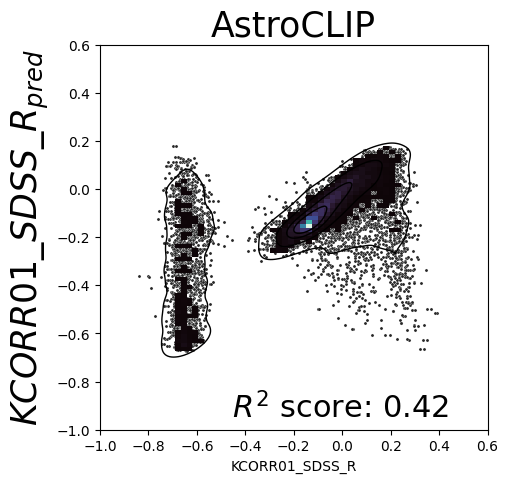

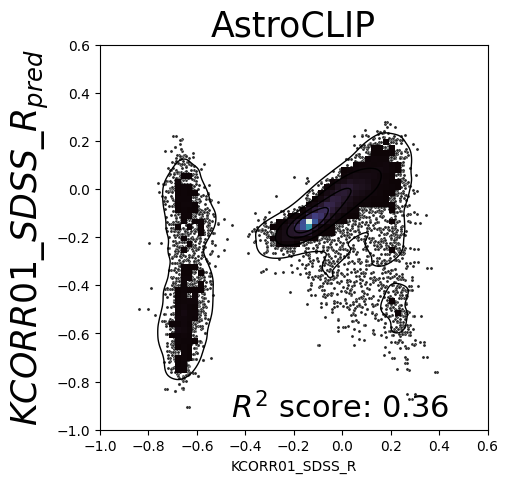

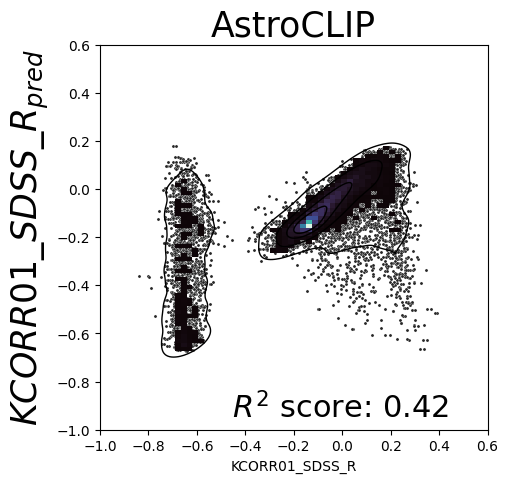

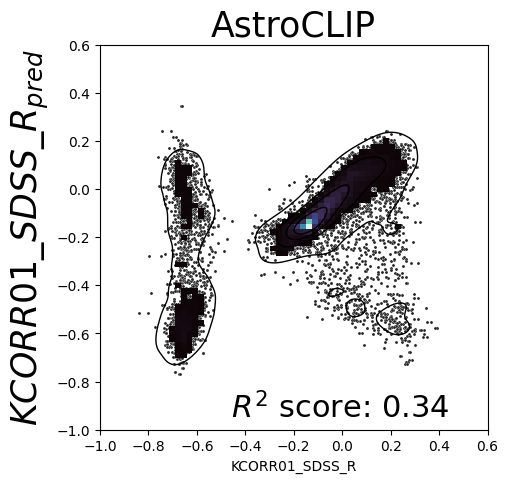

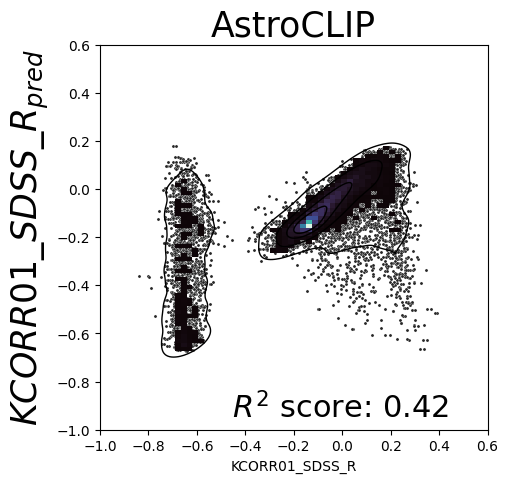

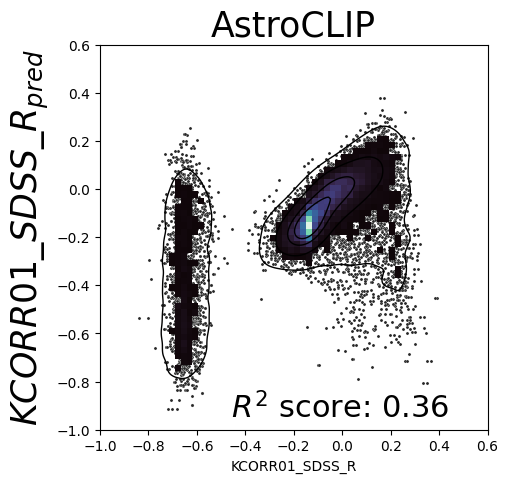

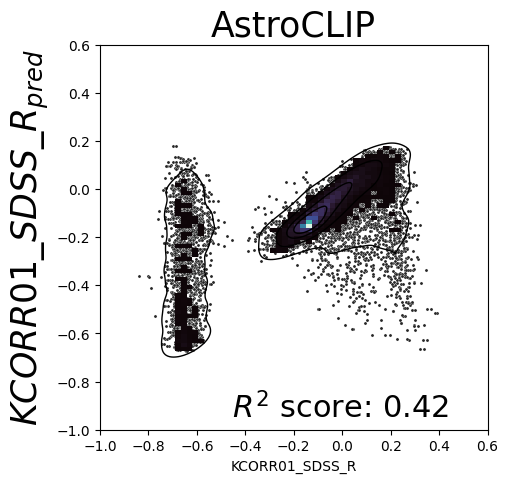

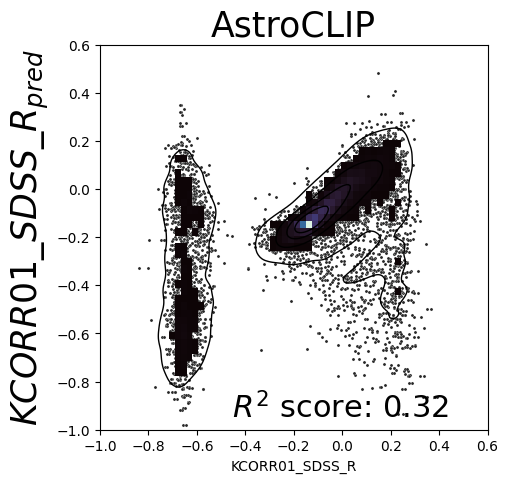

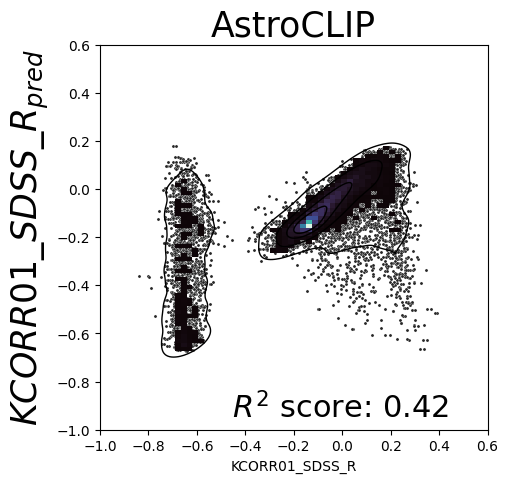

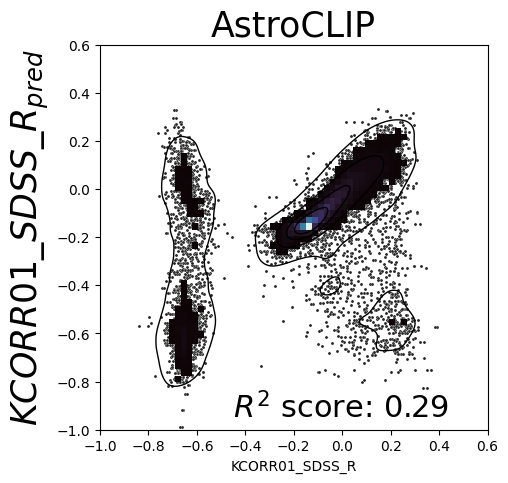

In [68]:
all_stats = {}
for i, mlp_hidden_dims in enumerate([ [32], [32, 32] , [32, 32, 32], [256], [256, 256], [1024, 1024, 1024] ]):
    preds_knn, preds_mlp, stats = estimate_dataset_column(mlp_hidden_dims = mlp_hidden_dims)
    all_stats[i]=stats

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the error
merged_df['error'] = merged_df['kcorr_sdss_01_r'] - merged_df['KCORR01_SDSS_R']
merged_df['error'] = merged_df['error'][merged_df['Z']<0.37]
# Plot the error distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['error'], kde=True, color="purple", bins=30)
plt.axvline(0, color='red', linestyle='--', label="No Error")
plt.xlabel("Error (Blanton Estimate - VAC Estimate)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Error Distribution of Blanton Estimate", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

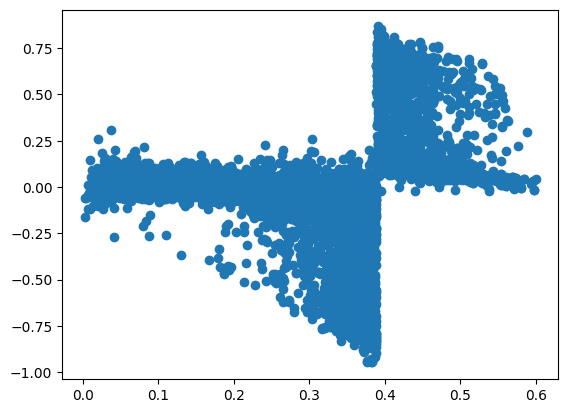

{'whiskers': [<matplotlib.lines.Line2D at 0x7f794c80be80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f794c818400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f794c80bbe0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f794c7fec70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f794c8c9460>],
 'means': []}

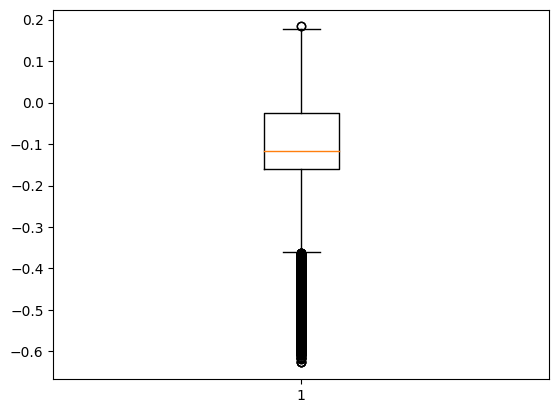

In [78]:
plt.boxplot(preds_mlp["AstroCLIP"])
# Me resulta rarisimo el tema del rescalamiento.... creo q es un problema del test set not being properly rescaled

Evaluating astroclip_image model...


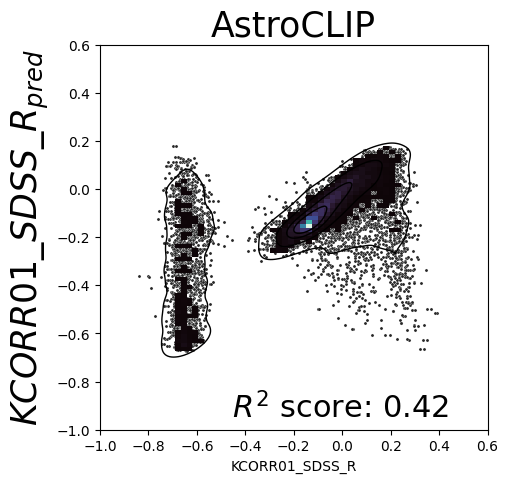

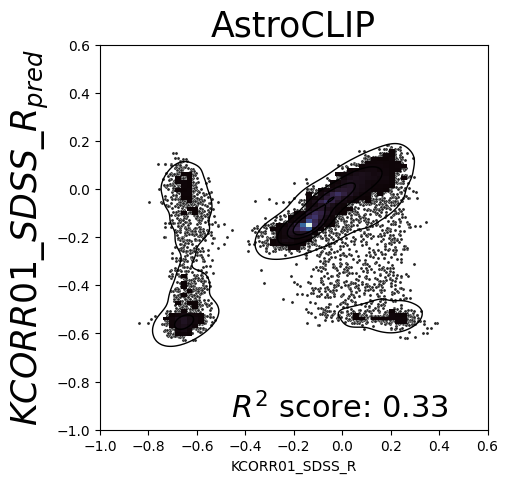

In [70]:
preds_knn, preds_mlp, stats = estimate_dataset_column(mlp_hidden_dims = [256,256,256,256,256])

In [71]:
stats

{'mae_knn': 0.0829254619353727,
 'mae_mlp': 0.085073344,
 'r2_knn': 0.42471238345367246,
 'r2_mlp': 0.3324138823923265}